In [1]:
import numpy as np
import pandas as pd
import sqlite3
import scrapbook as sb
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 20]

D:\Anaconda\envs\HW4\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [3]:
# Parameters
from_date = "2021-11-30 00:00:00"
to_date = "2021-12-07 00:00:00"
token = "AVAX"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


# Read data from database

In [4]:
prices = pd.read_sql(f'''
SELECT
    * 
FROM ohlc 
WHERE
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)

prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-30 00:00:00,117.77,120.99,116.71,120.84,87013.421,1.034175e+07,AVAX,AVAX
2021-11-30 01:00:00,120.80,121.63,118.36,120.03,72970.942,8.761341e+06,AVAX,AVAX
2021-11-30 02:00:00,120.00,120.48,117.91,120.48,45253.792,5.397404e+06,AVAX,AVAX
2021-11-30 03:00:00,120.49,122.50,119.89,120.01,63014.270,7.644612e+06,AVAX,AVAX
2021-11-30 04:00:00,119.92,119.97,116.22,118.27,68814.801,8.116189e+06,AVAX,AVAX


1. Create a jupyter notebook template to do the following - for a given token and date range:
    - calculate the hourly return by timestamp
    - calculate the hourly volatility (you can use the formula we went over in class)
    - calculate maximum drawdown up to that hour for each hour
    - then plot in a 2x2 grid:
        - hourly return
        - hourly vol
        - maximum drawdown
        - close prices
        - color each day on the graph
        

# Calculate the hourly return

In [5]:
prices['return'] = np.log(prices.close / prices.close.shift(1))

# Calculate the hourly volatility

In [6]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc ** 2
    cc_sq = cc ** 2
    rs = ho * (ho - co) + lo *(lo - co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [7]:
prices['volatility'] = vol_ohlc(prices)

# Calculate maximum drawdown

In [8]:
def mdd_ohlc(df):
    c = df.close
    
    drawdown = np.log(c / np.maximum.accumulate(c))
    max_drawdown = np.minimum.accumulate(drawdown)
    
    return max_drawdown

In [9]:
prices['mdd'] = mdd_ohlc(prices)

# Plot in a 2x2 grid:
- hourly return
- hourly vol
- maximum drawdown
- close prices  
\# Note: color each day on the graph

In [10]:
def series_plot(data, ax):
    data.plot(ax=ax)
    
    # color each day
    start_of_days = data.between_time('00:00:00', '00:00:00').index.tolist()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1) # vertical span, x: start of x coordinate, y: end of x coordinate

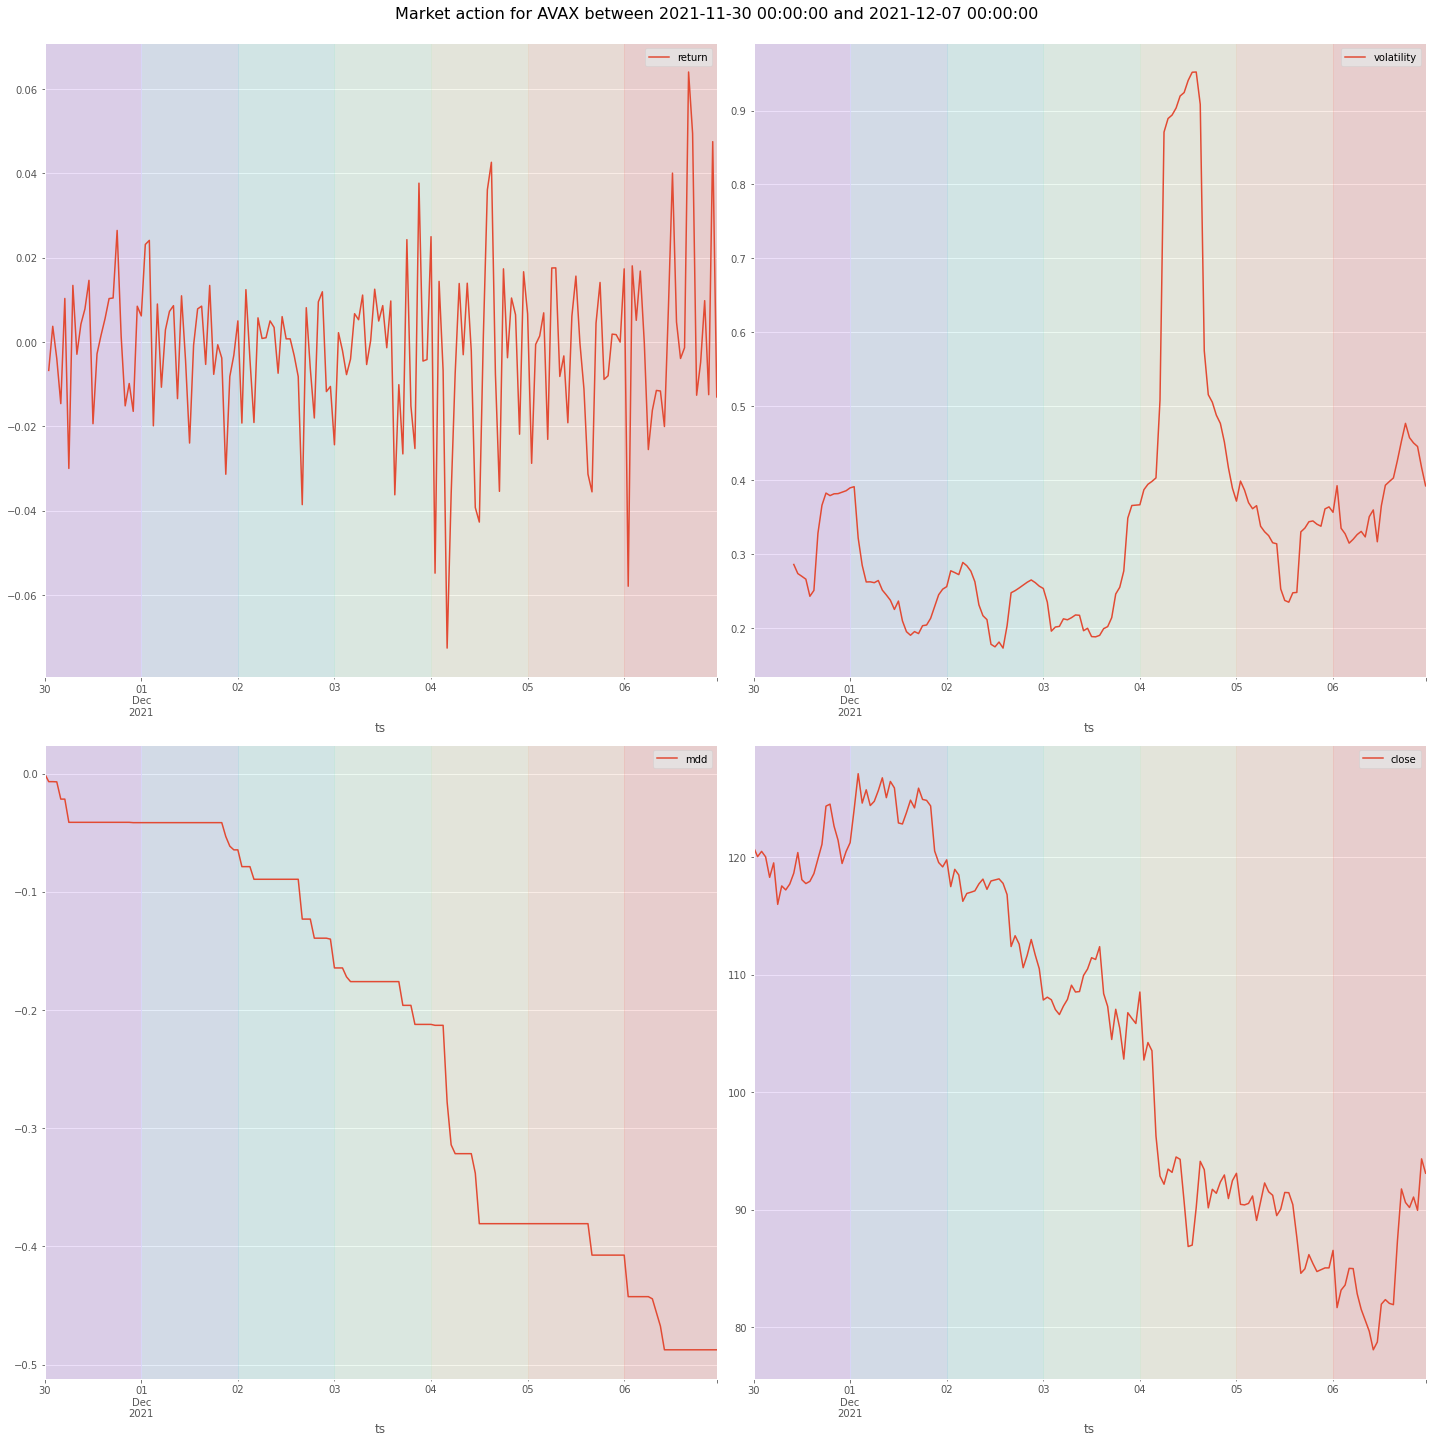

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
series_plot(prices[['return']], axes[0,0])
series_plot(prices[['volatility']], axes[0,1])
series_plot(prices[['mdd']], axes[1,0])
series_plot(prices[['close']], axes[1,1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}', fontsize=16, y=1)
plt.tight_layout()

# Gather info for the runner notebook
- avg hourly return by run
- avg volatility by run
- maximum drawdown over the entire period of each run
- range of last close price - first close price

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('avg_return', prices['return'].mean())
sb.glue('avg_volatility', prices['volatility'].mean())
sb.glue('max_drawdown', prices['mdd'].min())
c_minus_first = prices['close'] - prices['close'].iloc[0]
sb.glue('range_of_close', c_minus_first.max() - c_minus_first.min())